In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.applications import InceptionV3, DenseNet121


2024-09-05 02:32:55.391006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 02:32:55.391124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 02:32:55.510959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the CSV files
train_df = pd.read_csv('/kaggle/input/icts-dataset-second/ICTS_DATASET_CROPPED/train_final.csv')
test_df = pd.read_csv('/kaggle/input/icts-dataset-second/ICTS_DATASET_CROPPED/test_final.csv')

# Convert class labels to strings
train_df['class'] = train_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

# Balance the dataset by oversampling the minority classes
class_counts = train_df['class'].value_counts()
max_class_count = class_counts.max()

balanced_train_df = train_df.copy()
for class_label in class_counts[class_counts < max_class_count].index:
    class_df = train_df[train_df['class'] == class_label]
    oversampled_class_df = class_df.sample(max_class_count, replace=True)
    balanced_train_df = pd.concat([balanced_train_df, oversampled_class_df], axis=0)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(balanced_train_df, test_size = 0.2, stratify = balanced_train_df['class'])


# Define data directories
train_image_dir = "/kaggle/input/icts-dataset-second/ICTS_DATASET_CROPPED/images/train"
test_image_dir = "/kaggle/input/icts-dataset-second/ICTS_DATASET_CROPPED/images/test"



In [3]:
from sklearn.utils.class_weight import compute_class_weight


In [4]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    directory=train_image_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_image_dir,
    x_col = 'filename',
    y_col = 'class',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'

)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_image_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(balanced_train_df['class']), y=balanced_train_df['class'])
class_weights_dict = dict(enumerate(class_weights))

num_classes = len(np.unique(balanced_train_df['class']))

input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)



Found 31618 validated image filenames belonging to 17 classes.
Found 6324 validated image filenames belonging to 17 classes.
Found 1968 validated image filenames belonging to 17 classes.


In [5]:
# InceptionV3 model
inception_base = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)
inception_output = Flatten()(inception_base.output)

# DenseNet model
densenet_base = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_layer)
densenet_output = Flatten()(densenet_base.output)

# Concatenate the outputs
combined_output = concatenate([inception_output, densenet_output])

# Add a fully connected layer
fc_layer = Dense(256, activation='relu')(combined_output)

# Add a final softmax layer
output_layer = Dense(num_classes, activation='softmax')(fc_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_inception_densenet.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    class_weight=class_weights_dict
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725503878.597955      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


650/989 ━━━━━━━━━━━━━━━━━━━━ 3:36 638ms/step - accuracy: 0.6300 - loss: 1.1734

W0000 00:00:1725504293.314988      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


989/989 ━━━━━━━━━━━━━━━━━━━━ 867s 613ms/step - accuracy: 0.7001 - loss: 0.9370 - val_accuracy: 0.9416 - val_loss: 0.1288 - learning_rate: 1.0000e-05
Epoch 2/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 412s 414ms/step - accuracy: 0.9595 - loss: 0.0966 - val_accuracy: 0.9787 - val_loss: 0.0606 - learning_rate: 1.0000e-05
Epoch 3/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 415s 417ms/step - accuracy: 0.9808 - loss: 0.0474 - val_accuracy: 0.9863 - val_loss: 0.0342 - learning_rate: 1.0000e-05
Epoch 4/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 414s 416ms/step - accuracy: 0.9860 - loss: 0.0343 - val_accuracy: 0.9929 - val_loss: 0.0231 - learning_rate: 1.0000e-05
Epoch 5/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 409s 411ms/step - accuracy: 0.9923 - loss: 0.0202 - val_accuracy: 0.9903 - val_loss: 0.0290 - learning_rate: 1.0000e-05
Epoch 6/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 407s 408ms/step - accuracy: 0.9923 - loss: 0.0178 - val_accuracy: 0.9756 - val_loss: 0.0903 - learning_rate: 1.0000e-05
Epoch 7/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 414s 416ms/

In [7]:

# Load the best model
best_model = load_model('best_model_inception_densenet.keras')

# Predict the test set
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")



62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step
Confusion Matrix:
 [[403   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0 134   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  83   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  55   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  55   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 102   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  55   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 158   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  87   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  69   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1 172   0   0   2   0]
 [  0   0   0   

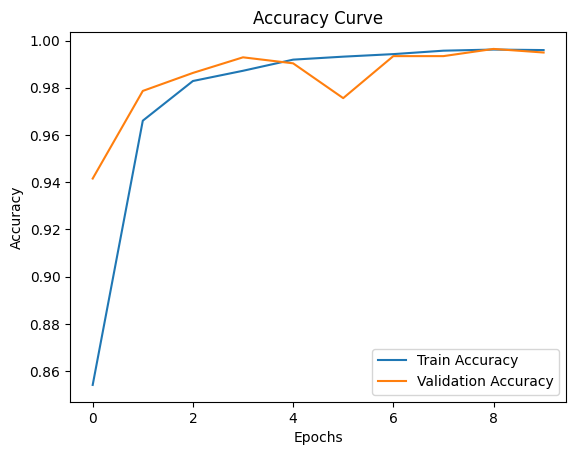

In [8]:
# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Plot accuracy curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()




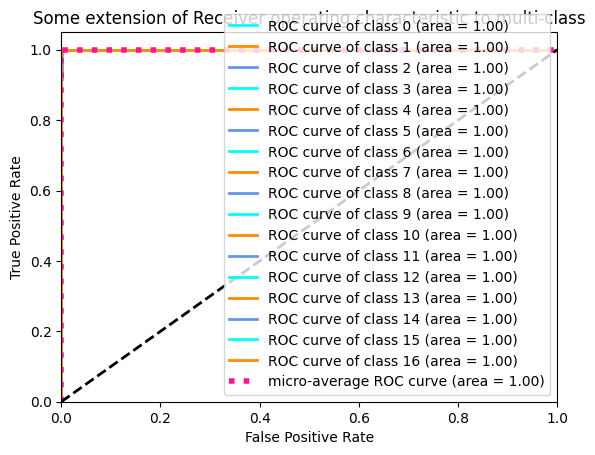

In [9]:
# Plot ROC curve for each class
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred_classes, classes=range(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [10]:
  # Calculate sensitivity and specificity for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print results for each class
for i, cls in enumerate(test_generator.class_indices.keys()):
    print(f"Class {cls}:")
    print(f"  Sensitivity: {sensitivity[i]:.4f}")
    print(f"  Specificity: {specificity[i]:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print()

# Calculate macro-average sensitivity and specificity
macro_sensitivity = np.mean(sensitivity)
macro_specificity = np.mean(specificity)
print("Macro-average Sensitivity:", macro_sensitivity)
print("Macro-average Specificity:", macro_specificity)  



Class 1:
  Sensitivity: 0.9975
  Specificity: 1.0000
  Accuracy: 0.9949

Class 10:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 11:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 12:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 13:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 14:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 15:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 16:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 17:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 2:
  Sensitivity: 1.0000
  Specificity: 0.9994
  Accuracy: 0.9949

Class 3:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9949

Class 4:
  Sensitivity: 1.0000
  Specificity: 0.9968
  Accuracy: 0.9949

Class 5:
  Sensitivity: 0.9829
  Specificity: 0.9994
  Accuracy: 0.9949

Class 6:
  Sensitivity: 1.0000
  Specificit

In [11]:
# Compile and train the VGG16 model individually
densenet_model = Model(inputs=densenet_base.input, outputs=Dense(num_classes, activation='softmax')(densenet_output))
densenet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('densenet_best_model.keras', monitor='val_loss', save_best_only=True)
    ]
)



Epoch 1/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7972 - loss: 0.7246

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


989/989 ━━━━━━━━━━━━━━━━━━━━ 622s 496ms/step - accuracy: 0.7973 - loss: 0.7241 - val_accuracy: 0.9965 - val_loss: 0.0109 - learning_rate: 1.0000e-05
Epoch 2/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 393s 395ms/step - accuracy: 0.9920 - loss: 0.0293 - val_accuracy: 0.9981 - val_loss: 0.0055 - learning_rate: 1.0000e-05
Epoch 3/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 406s 407ms/step - accuracy: 0.9964 - loss: 0.0136 - val_accuracy: 0.9979 - val_loss: 0.0059 - learning_rate: 1.0000e-05
Epoch 4/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 425s 427ms/step - accuracy: 0.9968 - loss: 0.0113 - val_accuracy: 0.9998 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 5/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 408s 410ms/step - accuracy: 0.9983 - loss: 0.0058 - val_accuracy: 0.9991 - val_loss: 0.0021 - learning_rate: 1.0000e-05


In [12]:
# Load the best densenet model
densenet_best_model = load_model('densenet_best_model.keras')

# Predict the test set using the densenet model
densenet_y_pred = densenet_best_model.predict(test_generator)
densenet_y_pred_classes = np.argmax(densenet_y_pred, axis=1)
densenet_y_true = test_generator.classes

# Generate confusion matrix for densenet
densenet_conf_matrix = confusion_matrix(densenet_y_true, densenet_y_pred_classes)

# Calculate overall accuracy for VGG16
densenet_accuracy = accuracy_score(densenet_y_true, densenet_y_pred_classes)

# Calculate precision, recall, and F1-score for each class
densenet_precision = precision_score(densenet_y_true, densenet_y_pred_classes, average='weighted')
densenet_recall = recall_score(densenet_y_true, densenet_y_pred_classes, average='weighted')
densenet_f1 = f1_score(densenet_y_true, densenet_y_pred_classes, average='weighted')

# Calculate sensitivity and specificity for each class
densenet_TP = np.diag(densenet_conf_matrix)
densenet_FP = np.sum(densenet_conf_matrix, axis=0) - densenet_TP
densenet_FN = np.sum(densenet_conf_matrix, axis=1) - densenet_TP
densenet_TN = np.sum(densenet_conf_matrix) - (densenet_TP + densenet_FP + densenet_FN)

densenet_sensitivity = np.mean(densenet_TP / (densenet_TP + densenet_FN))
densenet_specificity = np.mean(densenet_TN / (densenet_TN + densenet_FP))



62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 233ms/step


In [13]:
# Print averaged results
print(f"densenet Accuracy: {densenet_accuracy:.4f}")
print(f"densenet Precision (Weighted): {densenet_precision:.4f}")
print(f"densenet Recall (Weighted): {densenet_recall:.4f}")
print(f"densenet F1-score (Weighted): {densenet_f1:.4f}")
print(f"densenet Sensitivity (Average): {densenet_sensitivity:.4f}")
print(f"densenet Specificity (Average): {densenet_specificity:.4f}")



densenet Accuracy: 0.9944
densenet Precision (Weighted): 0.9944
densenet Recall (Weighted): 0.9944
densenet F1-score (Weighted): 0.9944
densenet Sensitivity (Average): 0.9959
densenet Specificity (Average): 0.9996


In [14]:
# Train individual InceptionV3 model
inceptionv3_model = Model(inputs=inception_base.input, outputs=Dense(num_classes, activation='softmax')(inception_output))
# Compile the InceptionV3 model

inceptionv3_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_inceptionv3 = inceptionv3_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    class_weight=class_weights_dict
)



Epoch 1/4
989/989 ━━━━━━━━━━━━━━━━━━━━ 507s 445ms/step - accuracy: 0.7846 - loss: 0.7937 - val_accuracy: 0.9799 - val_loss: 0.0566 - learning_rate: 1.0000e-05
Epoch 2/4
989/989 ━━━━━━━━━━━━━━━━━━━━ 452s 425ms/step - accuracy: 0.9828 - loss: 0.0529 - val_accuracy: 0.9949 - val_loss: 0.0139 - learning_rate: 1.0000e-05
Epoch 3/4
989/989 ━━━━━━━━━━━━━━━━━━━━ 405s 407ms/step - accuracy: 0.9899 - loss: 0.0287 - val_accuracy: 0.9972 - val_loss: 0.0077 - learning_rate: 1.0000e-05
Epoch 4/4
989/989 ━━━━━━━━━━━━━━━━━━━━ 406s 408ms/step - accuracy: 0.9935 - loss: 0.0196 - val_accuracy: 0.9986 - val_loss: 0.0044 - learning_rate: 1.0000e-05


In [15]:
# Predict the test set with InceptionV3 model
y_pred_inceptionv3 = inceptionv3_model.predict(test_generator)
y_pred_inceptionv3_classes = np.argmax(y_pred_inceptionv3, axis=1)

# Calculate metrics for InceptionV3
print("InceptionV3 Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_inceptionv3_classes):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_inceptionv3_classes, average=None)}")
print(f"Recall: {recall_score(y_true, y_pred_inceptionv3_classes, average=None)}")
print(f"F1 Score: {f1_score(y_true, y_pred_inceptionv3_classes, average=None)}")

# Calculate sensitivity and specificity for InceptionV3
conf_matrix_inceptionv3 = confusion_matrix(y_true, y_pred_inceptionv3_classes)
TP_inceptionv3 = np.diag(conf_matrix_inceptionv3)
FP_inceptionv3 = np.sum(conf_matrix_inceptionv3, axis=0) - TP_inceptionv3
FN_inceptionv3 = np.sum(conf_matrix_inceptionv3, axis=1) - TP_inceptionv3
TN_inceptionv3 = np.sum(conf_matrix_inceptionv3) - (TP_inceptionv3 + FP_inceptionv3 + FN_inceptionv3)

sensitivity_inceptionv3 = TP_inceptionv3 / (TP_inceptionv3 + FN_inceptionv3)
specificity_inceptionv3 = TN_inceptionv3 / (TN_inceptionv3 + FP_inceptionv3)

print(f"Sensitivity: {sensitivity_inceptionv3}")
print(f"Specificity: {specificity_inceptionv3}")



62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step
InceptionV3 Model Evaluation:
Accuracy: 0.9924
Precision: [1.         0.99259259 1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.86075949
 0.99428571 1.         1.         0.99324324 0.99610895]
Recall: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.98850575 0.98550725
 0.99428571 1.         0.99047619 0.99324324 0.96240602]
F1 Score: [1.         0.99628253 1.         1.         1.         1.
 1.         1.         1.         1.         0.99421965 0.91891892
 0.99428571 1.         0.99521531 0.99324324 0.9789675 ]
Sensitivity: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.98850575 0.98550725
 0.99428571 1.         0.99047619 0.99324324 0.96240602]
Specificity: [1.         0.99945474 1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.9942074